##Recommender Systems

#### Yandong Han


In [1]:
import json
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [2]:
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

# def read_json(file):
#     dataset = {}
#     keys = []
#     with open(file) as file_lines:
#         for count, line in enumerate(file_lines):
#             data = json.loads(line.strip())
#             if count ==0:
#                 dataset, keys = init_ds(data)
#             for k in keys:
#                 dataset[k].append(data[k])
                
#         return pd.DataFrame(dataset)
def read_json(file):
    data = pd.read_json(file, lines=True, orient='columns', chunksize=1000000)
    for i in data:
        df = i
        break

    return df

def predict_rating(search_user,business_id):
    sum = 0
    user_similar = all_pair_similarities.loc[search_user]
    users_purchased = df_train.index[df_train[business_id] != 0].tolist()
    purchased_similar_rate = user_similar[user_similar.index.isin(users_purchased)]
    purchased_similar_rate=purchased_similar_rate.sort_values(ascending=False)
    top= purchased_similar_rate[0:20]
    for users,cos in top.iteritems():
        sum += df_train.loc[users,business_id]*cos
    top_sum= top.sum()
    if(top_sum!=0):
        cf = sum/top_sum
    else:
        cf = 0
    return cf

def hybrid(search_user,business_id):
    sum = 0
 
    user_similar = all_pair_similarities.loc[search_user]
    users_purchased = df_train.index[df_train[business_id] != 0].tolist()
    purchased_similar_rate = user_similar[user_similar.index.isin(users_purchased)]
    purchased_similar_rate=purchased_similar_rate.sort_values(ascending=False)
    top= purchased_similar_rate[0:20]

    for users,cos in top.iteritems():
        sum += df_train.loc[users,business_id]*cos
    top_sum= top.sum()
    if(top_sum!=0):
        cf = sum/top_sum
    else:
        similar_total = 0
        categories = df_business.loc[business_id,'categories']
        business_rank = df_business.index[df_business['categories'] == categories].tolist()
        
        for i in business_rank:
            similar_total = similar_total+predict_rating(search_user,i)
        business_similar = similar_total/len(business_rank)
        cf = (business_similar + df_business.loc[business_id,'stars'])/2
    return cf
        

In [3]:
train = read_json('train.json')
test=read_json('test.json')
user = read_json('user.json')
businesses=read_json('business.json')

In [4]:
df_train = pd.DataFrame(0,index=user.user_id.tolist(),columns=businesses.business_id.tolist())
for i in range(len(train)):
    user_id = train.user_id[i]
    business_id = train.business_id[i]
    stars = train.stars[i]
    df_train.loc[user_id,business_id] = stars
# df_train.head() 

df_business = pd.DataFrame(0,columns=["categories","stars"], index=businesses.business_id.tolist())
for i in range(len(businesses)):
    business_id = businesses.business_id[i]
    stars = businesses.stars[i]
    categories =  businesses.categories[i]
    df_business.loc[business_id,"stars"] = stars
    df_business.loc[business_id,"categories"] = categories
# df_business.head()   

df_test = pd.DataFrame(0,index=user.user_id,columns=businesses.business_id )
for i in range(len(test)):
    user_id = test.user_id[i]
    business_id = test.business_id[i]
    stars = test.stars[i]
    df_test.loc[user_id,business_id] = stars

### Part 1- (a)(1)

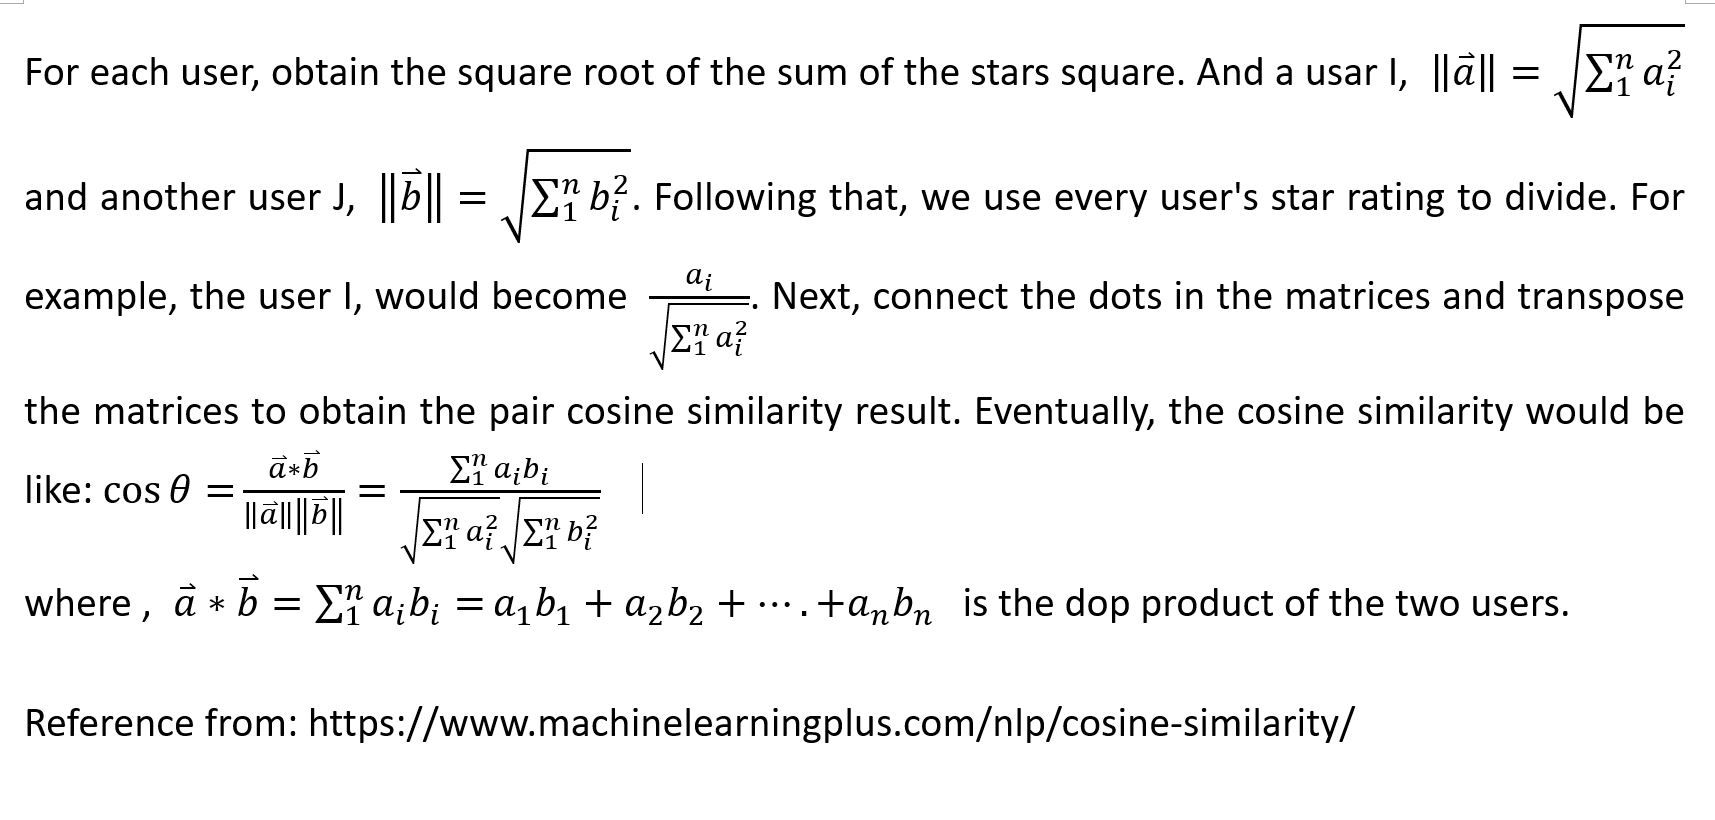

### part 1- (a)(2) Report the time for computing allpair similarities 

In [6]:
start_time = time.time() 
df_array = df_train.to_numpy()
l2 = np.sqrt((df_array * df_array).sum(axis=1))
df_array = df_array/l2[:, np.newaxis]
cosine = np.dot(df_array, df_array.T)
end_time = time.time()-start_time
print("computing time",end_time)

computing time 119.60059666633606


### Part 1 - (a)(3)  Report the similarities between the following pairs of users 
accoring to the table,

In [7]:
cosine = np.nan_to_num(cosine)
all_pair_similarities = pd.DataFrame(cosine,columns=user.user_id, index=user.user_id)
print("Pairs 1: ", all_pair_similarities["HwmTzORmEfa9HgSfmA0RQw"]['xXDYa_irvrCYyavLS7-nuw'])
print("Pairs 2: ", all_pair_similarities["tnO-RiRJsUb70VDGwodXYA"]['lCYC5Ei9tIFBaW1AQfRu7A'])
print("Pairs 3: ", all_pair_similarities["9SqPSd2HnDJIM3v4_j9LYA"]['bxPlCsoHCIOrBl0wmno4Wg'])
print("Pairs 4: ", all_pair_similarities["n50GnfiJYA95JZZMJKBdJw"]['3zuiM8dt9bq-1oHjpiEfrg'])

Pairs 1:  0.08345822698898138
Pairs 2:  0.08514504649590413
Pairs 3:  0.02167693433107724
Pairs 4:  0.0


### Part 1 - (b)(1) Report the predicted ratings for a given user with user id=’xXDYa irvrCYyavLS7-nuw’ to he following five candidate businesses 

In [8]:
candidate_business = ['7hWNnAj4VwK6FAUBN8E8lg',
'hFT3HuxVZJb1uYEsYfp-0A',
'FnNbl49xnN5RkBDk_8muAw',
'thlQQwjsT6RmoqzoD87UqQ',
'JjcJVqhZXhP4tvOhg3fnag']


search_user='xXDYa_irvrCYyavLS7-nuw'

for item in candidate_business:
    cf = predict_rating(search_user,item)
    print(cf)

4.819543812864684
4.666492649965299
5.000000000000001
4.664602436904922
4.999999999999999


### Part 1 - (b) (2) the overall RMSE on the test data 


In [9]:

 

sum = 0
for i in range(len(test)):
    user_id = test.user_id[i]
    business_id = test.business_id[i]
    stars = test.stars[i]
    predict = predict_rating(user_id,business_id)
    sum= sum+(predict-stars)**2
RMSE=math.sqrt(sum/len(test))
RMSE


2.2957462005589497

### Part 1 - (c) histograms and discuss your findings from them
By observing the two histogram, there is a decreasing number of stars. The most of users give fewer than 50 stars and they only give rate one time. Moreover, their distribution is very similar. The two sets of data are mainly focused on 0 to 50.


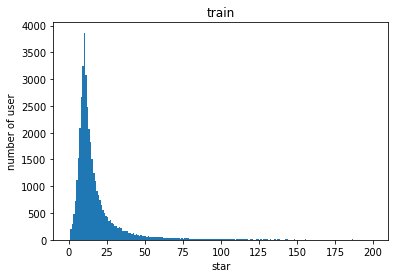

In [10]:
data=[]
for id, items in df_train.iterrows():
    number_rate = (df_train.loc[id].values > 0).sum()
    if(number_rate>0):
        data.append(number_rate)
        
plt.title('train')
plt.xlabel('star')
plt.ylabel('number of user')
plt.hist(data,bins=200,range=[0,200])
plt.show()

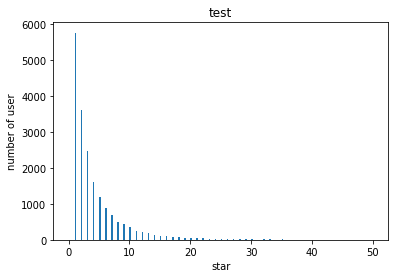

In [11]:
data=[]
for id, item in df_test.iterrows():
    number_rate = (df_test.loc[id].values > 0).sum()
    if(number_rate>0):
        data.append(number_rate)
plt.title('test')
plt.xlabel('star')
plt.ylabel('number of user')
plt.hist(data,bins=200,range=[0,50])
plt.show()

### Part 1 - (d) Report RMSE for the two groups of users on test data separately (10 pts), discuss the observation you found from the results (5 pts).
Group A is the set of users who generated no more than 2 ratings in the training data, the RMSE is 3.7927139321494283.
Group B is the set of users who generated more than 2 ratings in the training data, the RMSE is 1.955222743942836.
When the two sets of RMSEs are compared, the user rate more data would have more prediction according when RMSE is more less.

In [12]:
sum_a = 0
count_a=0

sum_b = 0
count_b=0

for i in range(len(test)):
    user_id = test.user_id[i]
    business_id = test.business_id[i]
    stars = test.stars[i]
    predict = predict_rating(user_id,business_id)
    all_train_user=(df_train.loc[user_id].values != 0).sum()
    
    if(all_train_user<=2):
        sum_a= sum_a+(predict-stars)**2
        count_a=count_a+1
    else:
        sum_b= sum_b+(predict-stars)**2
        count_b=count_b+1
        
        
    
group_a_RMSE=math.sqrt(sum_a/count_a)
print("no more than 2 ratings",group_a_RMSE)

group_b_RMSE=math.sqrt(sum_b/count_b)
print("more than 2 ratings",group_b_RMSE)

no more than 2 ratings 3.7927139321494283
more than 2 ratings 1.955222743942836


### Part 2 (a) Describe your design of the hybrid algorithm to improve the RMSE
A hybrid algorithm is an algorithm that combines two or more other algorithms that solve the same problem. If a business has no rating, it looks for others in the same category, then compute the predict rating for all of them to obtain the average prediction rating. Therefore, the final predict rating is calculated by between business rating and average of predicted rating. 


### Part 2 (b) report the overall RMSE on test set
RMSE on test set is 1.614028057372487

In [13]:
sum = 0
for i in range(len(test)):
    user_id = test.user_id[i]
    business_id = test.business_id[i]
    stars = test.stars[i]
    predict = hybrid(user_id,business_id)
    sum= sum+(predict-stars)**2
RMSE=math.sqrt(sum/len(test))
RMSE

1.614028057372487

### Part 2 (c) Report and compare the RMSE of user-based CF and the hybrid approach on user group A and B in Q1d (10 pts). Discuss your findings from the resulting RMSE (5 pts).
While the RMSE is lower than the user-based Collaborative filtering, Group A still outperforms Group B. The RMSE decreases mostly, as a reson there is new business then it would receive a forecast of 0, and the prediction value will be closer to the ground truth after using the hybrid technique.

In [14]:
sum_a = 0
count_a=0

sum_b = 0
count_b=0

for i in range(len(test)):
    user_id = test.user_id[i]
    business_id = test.business_id[i]
    stars = test.stars[i]
    predict = hybrid(user_id,business_id)
    all_train_user=(df_train.loc[user_id].values != 0).sum()
    
    if(all_train_user<=2):
        sum_a= sum_a+(predict-stars)**2
        count_a=count_a+1
    else:
        sum_b= sum_b+(predict-stars)**2
        count_b=count_b+1
        
        
    
group_a_RMSE=math.sqrt(sum_a/count_a)
print("no more than 2 ratings",group_a_RMSE)

group_b_RMSE=math.sqrt(sum_b/count_b)
print("more than 2 ratings",group_b_RMSE)

no more than 2 ratings 2.2151828818949877
more than 2 ratings 1.4964901540471236
